ref: https://www.kaggle.com/c/covid19-global-forecasting-week-1/discussion/137796

# Loading Data

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import integrate, optimize
import pandas as pd
import os
date='3/29/20'
odir = date.replace('/','_') + '/'
df= pd.read_csv("../countries-spread-rate/"+odir+"confirmed-data-top-affected-countries.csv")
try:  
    os.mkdir(odir)  
except OSError as error:  
    print(error)
df["Country"].values

[Errno 17] File exists: '3_29_20/'


array(['US', 'Italy', 'China', 'Spain', 'Germany', 'France', 'Iran',
       'United Kingdom', 'Switzerland', 'Netherlands', 'Belgium',
       'Korea, South', 'Turkey', 'Austria', 'Canada', 'Portugal',
       'Norway', 'Brazil', 'Israel', 'Australia', 'Sweden', 'Czechia',
       'Ireland', 'Denmark', 'Malaysia', 'Chile', 'Luxembourg', 'Ecuador',
       'Japan', 'Poland', 'Romania', 'Pakistan', 'Russia', 'Philippines',
       'Thailand', 'Saudi Arabia', 'Indonesia', 'South Africa', 'Finland',
       'Greece', 'India', 'Iceland', 'Panama', 'Dominican Republic',
       'Peru', 'Mexico', 'Singapore', 'Argentina', 'Serbia', 'Slovenia',
       'Croatia', 'Diamond Princess', 'Colombia', 'Estonia', 'Qatar',
       'Egypt', 'United Arab Emirates', 'Iraq', 'New Zealand', 'Algeria',
       'Bahrain', 'Morocco', 'Ukraine'], dtype=object)

In [2]:
df.head()

,Country,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,...,3/20/20,3/21/20,3/22/20,3/23/20,3/24/20,3/25/20,3/26/20,3/27/20,3/28/20,3/29/20
0,US,1,1,2,2,5,5,5,5,5,...,19100,25489,33276,43847,53740,65778,83836,101657,121478,140886
1,Italy,0,0,0,0,0,0,0,0,0,...,47021,53578,59138,63927,69176,74386,80589,86498,92472,97689
2,China,548,643,920,1406,2075,2877,5509,6087,8141,...,81250,81305,81435,81498,81591,81661,81782,81897,81999,82122
3,Spain,0,0,0,0,0,0,0,0,0,...,20410,25374,28768,35136,39885,49515,57786,65719,73235,80110
4,Germany,0,0,0,0,0,1,4,4,4,...,19848,22213,24873,29056,32986,37323,43938,50871,57695,62095


In [3]:
df_pop=pd.read_csv("population_by_country_2020.csv")
df_pop.head()


,Country (or dependency),Population (2020),Yearly Change,Net Change,Density (P/Km²),Land Area (Km²),Migrants (net),Fert. Rate,Med. Age,Urban Pop %,World Share
0,China,1439323776,0.39%,5540090,153,9388211,-348399.0,1.7,38,61%,18.47%
1,India,1380004385,0.99%,13586631,464,2973190,-532687.0,2.2,28,35%,17.70%
2,United States,331002651,0.59%,1937734,36,9147420,954806.0,1.8,38,83%,4.25%
3,Indonesia,273523615,1.07%,2898047,151,1811570,-98955.0,2.3,30,56%,3.51%
4,Pakistan,220892340,2.00%,4327022,287,770880,-233379.0,3.6,23,35%,2.83%


In [4]:
from matplotlib import rc
import matplotlib
#matplotlib.rc('text.latex', preamble='\\usepackage{txfonts}')


#rc('text', usetex=True)
#rc('font', family='serif')
#rc('font', serif='times')
rc('mathtext', default='sf')
rc("lines", markeredgewidth=1)
rc("lines", linewidth=2)
rc('axes', labelsize=16)  # 24
rc("axes", linewidth=0.5)  # 2)
rc('xtick', labelsize=14)
rc('ytick', labelsize=14)
rc('legend', fontsize=10)  # 16
rc('xtick.major', pad=6)  # 8)
rc('ytick.major', pad=6)  # 8)
rc('xtick.minor', size=5)  # 8)
rc('ytick.minor', size=5)  # 8)

# SEIR Model with curve_fit

In [5]:
import itertools
marker = itertools.cycle(( '*','+', '.', 'o', '*')) 
def seir(y, x, R0, Tr, Tl):
    gamma=1./Tr
    beta=R0*gamma
    sigma=1./Tl
    sus = -beta*y[0]*y[2]/N
    expo = (beta*y[0]*y[2]/N)-sigma*y[1]
    infected = sigma*y[1] - gamma*y[2]
    reco = gamma*y[2]
    return sus, expo, infected, reco
## 5.5 tl, 2.5 tr
def fit_ode(x,  R0, Tr, Tl):
    y= integrate.odeint(seir, (sus0, exp0, inf0, rec0), x, args=( R0, Tr, Tl))
    #return y[:,2] + y[:,3]
    return y[:,3]
def fit_country(country,population,bounds=([3,7,2], [10,10,3])):#([3,7,2], [10,10,3]))([1,1,1],[15,15,15]): #2-3, T_R=7-10. And R_0=3-10
    ydata= df[df["Country"]==country].values[0,1:]
    ydata = np.array(ydata, dtype=float)
    #xdata = np.array(xdata, dtype=float)
    idx=np.where(ydata>50)[0][0]
    ydata=ydata[idx:]
    xdata= np.arange(len(ydata))  #+ idx
#    xdata=xdata[idx:]
    global N, inf0, sus0,rec0,exp0
    #print(xdata,ydata)
    N = population
    '''
    inf0 = ydata[0]
    sus0 = N - inf0 -inf0*5
    rec0 = 0.0
    exp0= inf0*5
    '''
    
    rec0 = ydata[0]
    inf0= 4 * rec0
    sus0= N - 6 * rec0
    exp0= rec0
    popt, pcov = optimize.curve_fit(fit_ode, xdata, ydata,bounds=bounds)
    perr = np.sqrt(np.diag(pcov))
    fitted = fit_ode(xdata, *popt)
    err=np.linalg.norm(fitted-ydata)

    la= country + " $R_0$ =  %3.1f, " %popt[0] + " $T_r$ = %3.1f,  "%popt[1] +" $T_l$ = %1.1f, " %popt[2]+ " err = %1.1f" %err

    plt.plot(xdata, ydata,marker = next(marker), linestyle='' ,label=country )
    plt.plot(xdata, fitted,label=la)
    
    plt.legend(fontsize=12)
    plt.yscale("log")
    #plt.ylabel("Confirmed Cases with fit(I+R)",fontsize=14)
    plt.ylabel("Confirmed Cases with fit R",fontsize=14)
    plt.xlabel("Days",fontsize=14)
    #print(country, " R0 =  %3.1f \t" %popt[0], ", Tr = %3.1f \t "%popt[1], ", Tl = %1.1f" %popt[2])
    plt.grid()
   # print(pcov)
   # plt.title(country)



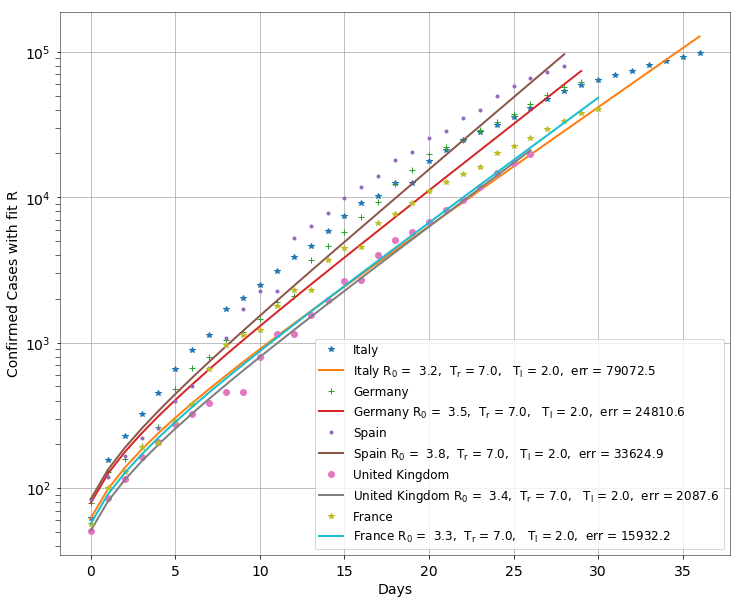

In [6]:
plt.figure(figsize=(12,10))
country='Italy'
population=df_pop[df_pop["Country (or dependency)"]=='Italy']["Population (2020)"].values[0] #'South Korea' #United States
fit_country(country,population)#bounds=([1,0,0],[15,30,15]))
country='Germany'
population=df_pop[df_pop["Country (or dependency)"]=='Germany']["Population (2020)"].values[0] #'South Korea' #United States
fit_country(country,population)#bounds=([1,0,0],[15,30,15]))
#country='China'
#population=df_pop[df_pop["Country (or dependency)"]=='China']["Population (2020)"].values[0] #'South Korea' #United States
#fit_country(country,population)#bounds=([1,0,0],[15,30,15]))
#country='China'
#population=df_pop[df_pop["Country (or dependency)"]=='China']["Population (2020)"].values[0] #'South Korea' #United States
#fit_country(country,population,bounds=([0,0,0],[30,14,14]))
#country='Korea, South'
#population=df_pop[df_pop["Country (or dependency)"]=='South Korea']["Population (2020)"].values[0] #'South Korea' #United States
#fit_country(country,population)#bounds=([1,0,0],[15,30,15]))
#plt.savefig("fit_1.png")
#plt.figure(figsize=(10,10))
#population=df_pop[df_pop["Country (or dependency)"]=='South Korea']["Population (2020)"].values[0] #'South Korea' #United States
#fit_country(country,population,bounds=([0,0,0],[30,14,14]))
#country='US'
#population=df_pop[df_pop["Country (or dependency)"]=='United States']["Population (2020)"].values[0] #'South Korea' #United States
#fit_country(country,population,bounds=([1,0,0],[15,30,15]))
#country='Iran'
#population=df_pop[df_pop["Country (or dependency)"]=='Iran']["Population (2020)"].values[0] #'South Korea' #United Statesfit_country(country,population,bounds=([0,0,0],[30,14,14]))
#fit_country(country,population,bounds=([0,1,1],[30,14,14]))
#plt.savefig("fit_2.png")

#plt.figure(figsize=(10,10))

country='Spain'
population=df_pop[df_pop["Country (or dependency)"]=='Spain']["Population (2020)"].values[0] #'South Korea' #United States
fit_country(country,population)#bounds=([1,0,0],[15,30,15]))
country='United Kingdom'
population=df_pop[df_pop["Country (or dependency)"]=='United Kingdom']["Population (2020)"].values[0] #'South Korea' #United States
fit_country(country,population)#bounds=([1,0,0],[15,30,15]))
country='France'
population=df_pop[df_pop["Country (or dependency)"]=='France']["Population (2020)"].values[0] #'South Korea' #United States
fit_country(country,population)#bounds=([1,0,0],[15,30,15]))
#plt.savefig("fit_3.png")

plt.savefig(odir+"fit_EU_new_interpretation_with_bounds.pdf")

# Normalised SIER model

In [7]:
def seir_norm(y,x, R0, Tr, Tl):
    gamma=1./Tr
    beta=R0*gamma
    sigma=1./Tl
    sus = -beta*y[0]*y[2]
    expo = (beta*y[0]*y[2])-sigma*y[1]
    infected = sigma*y[1] - gamma*y[2]
    reco = gamma*y[2]
    return sus, expo, infected, reco
def fit_ode_norm(x,  R0, Tr, Tl):
    return integrate.odeint(seir_norm, (sus0, exp0, inf0, rec0), x, args=( R0, Tr, Tl),atol=1e-16)[:,2]
#integrate.solve_ivp(seir_norm, [sus0, exp0, inf0, rec0], args=( R0, Tr, Tl),method='RK45').y[:,2]
def fit_country_norm(country,population,bounds=([3,1,1], [5,12,12])):
    ydata= df[df["Country"]==country].values[0,1:]
    ydata = np.array(ydata, dtype=float)
    #xdata = np.array(xdata, dtype=float)
    idx=np.where(ydata>100)[0][0]
    ydata=ydata[idx:]
    xdata= np.arange(len(ydata))  #+ idx
#    xdata=xdata[idx:]
    global N, inf0, sus0,rec0,exp0

    #print(xdata,ydata)
    N = population
    inf0 = ydata[0]/N
    exp0= inf0*10
    sus0 = 1 - rec0 - exp0
    rec0 = inf0*.1
    
    popt, pcov = optimize.curve_fit(fit_ode_norm, xdata, ydata/N,bounds=bounds)
    fitted = fit_ode_norm(xdata, *popt)
    err=np.linalg.norm(fitted-ydata)
    la=country, " R0 =  %3.1f " %popt[0], " Tr = %3.1f  "%popt[1], " Tl = %1.1f" %popt[2], " err = %1.1f" %err
    plt.plot(xdata, ydata/N, 'o', mec = 'r',label=country)
    plt.plot(xdata, fitted,label=la)
    plt.legend()
    plt.yscale("log")
  #  print(country, " R0 =  %3.3f \t" %popt[0], ", Tr = %3.3f \t "%popt[1], ", Tl = %3.3E" %popt[2])
   # print(pcov)
   # plt.title(country)



'\ncountry=\'Spain\'\npopulation=df_pop[df_pop["Country (or dependency)"]==\'Spain\']["Population (2020)"].values[0] #\'South Korea\' #United States\nfit_country_norm(country,population)#bounds=([1,0,0],[15,30,15]))\ncountry=\'United Kingdom\'\npopulation=df_pop[df_pop["Country (or dependency)"]==\'United Kingdom\']["Population (2020)"].values[0] #\'South Korea\' #United States\nfit_country_norm(country,population)#bounds=([1,0,0],[15,30,15]))\ncountry=\'France\'\npopulation=df_pop[df_pop["Country (or dependency)"]==\'France\']["Population (2020)"].values[0] #\'South Korea\' #United States\nfit_country_norm(country,population)#bounds=([1,0,0],[15,30,15]))\n#plt.savefig("fit_3.png")\n\n#plt.savefig("fit_EU_normalised.png")\n'

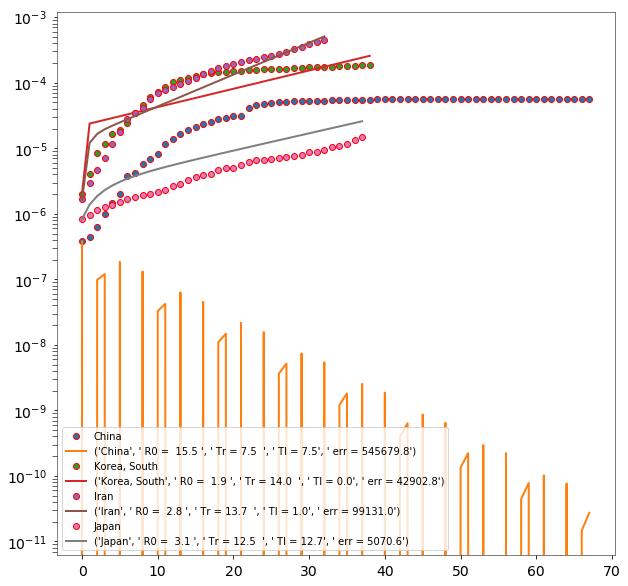

In [8]:
plt.figure(figsize=(10,10))
#country='Italy'
#population=df_pop[df_pop["Country (or dependency)"]=='Italy']["Population (2020)"].values[0] #'South Korea' #United States
#fit_country_norm(country,population)#bounds=([1,0,0],[15,30,15]))
#country='Germany'
#population=df_pop[df_pop["Country (or dependency)"]=='Germany']["Population (2020)"].values[0] #'South Korea' #United States
#fit_country_norm(country,population)#bounds=([1,0,0],[15,30,15]))
country='China'
population=df_pop[df_pop["Country (or dependency)"]=='China']["Population (2020)"].values[0] #'South Korea' #United States
#fit_country_norm(country,population)#bounds=([1,0,0],[15,30,15]))
#country='China'
#population=df_pop[df_pop["Country (or dependency)"]=='China']["Population (2020)"].values[0] #'South Korea' #United States
fit_country_norm(country,population,bounds=([1,1,1],[30,14,14]))
country='Korea, South'
population=df_pop[df_pop["Country (or dependency)"]=='South Korea']["Population (2020)"].values[0] #'South Korea' #United States
#fit_country_norm(country,population)#bounds=([1,0,0],[15,30,15]))
#plt.savefig("fit_1.png")
#plt.figure(figsize=(10,10))
#population=df_pop[df_pop["Country (or dependency)"]=='South Korea']["Population (2020)"].values[0] #'South Korea' #United States
fit_country_norm(country,population,bounds=([0,0,0],[30,14,14]))
#country='US'
#population=df_pop[df_pop["Country (or dependency)"]=='United States']["Population (2020)"].values[0] #'South Korea' #United States
#fit_country_norm(country,population,bounds=([1,0,0],[15,30,15]))
country='Iran'
population=df_pop[df_pop["Country (or dependency)"]=='Iran']["Population (2020)"].values[0] #'South Korea' #United Statesfit_country(country,population,bounds=([0,0,0],[30,14,14]))
fit_country_norm(country,population,bounds=([0,1,1],[30,14,14]))
country='Japan'
population=df_pop[df_pop["Country (or dependency)"]=='Japan']["Population (2020)"].values[0] #'South Korea' #United Statesfit_country(country,population,bounds=([0,0,0],[30,14,14]))
fit_country_norm(country,population,bounds=([0,1,1],[30,14,14]))
#plt.savefig("fit_2.png")

#plt.figure(figsize=(10,10))
'''
country='Spain'
population=df_pop[df_pop["Country (or dependency)"]=='Spain']["Population (2020)"].values[0] #'South Korea' #United States
fit_country_norm(country,population)#bounds=([1,0,0],[15,30,15]))
country='United Kingdom'
population=df_pop[df_pop["Country (or dependency)"]=='United Kingdom']["Population (2020)"].values[0] #'South Korea' #United States
fit_country_norm(country,population)#bounds=([1,0,0],[15,30,15]))
country='France'
population=df_pop[df_pop["Country (or dependency)"]=='France']["Population (2020)"].values[0] #'South Korea' #United States
fit_country_norm(country,population)#bounds=([1,0,0],[15,30,15]))
#plt.savefig("fit_3.png")

#plt.savefig("fit_EU_normalised.png")
'''

# SIER using minimising least square error
 ref: https://www.kaggle.com/anjum48/seir-model-with-intervention

In [304]:
from scipy.optimize import minimize
from sklearn.metrics import mean_squared_log_error, mean_squared_error
def get_data(country,l=None):
    ydata= df[df["Country"]==country].values[0,1:]
    ydata = np.array(ydata, dtype=float)
    idx=np.where(ydata>=10)[0][0]
    idx2= np.where(ydata>=1)[0][0]
    ydata=ydata[idx:]
    
    idx1= np.where(ydata>=500)[0][0]
    ydata=ydata[:idx1]
    
    if l!=None:
        ydata = ydata[:l]
    max_days=len(ydata)
    xdata= np.arange(max_days)
    return xdata,ydata, idx-idx2


def seir_ivp(x,y, R0, Tr, Tl):
    gamma=1./Tr
    beta=R0*gamma
    sigma=1./Tl
    sus = -beta*y[0]*y[2]/N
    expo = (beta*y[0]*y[2]/N)-sigma*y[1]
    infected = sigma*y[1] - gamma*y[2]
    reco = gamma*y[2]
    return sus, expo, infected, reco

def eval_model_seir(params,xdata,ydata,Ti,population,return_sol=False): # params: to optimize over


    N = population
    max_days=len(ydata)
    rec0 = ydata[0]
    inf0= 4 * rec0
    sus0= N - 6 * rec0
    exp0= rec0

#    R0=3.0
#    Tr=10
#    Tl=6
    R0,Tr,Tl=params

    sol = integrate.solve_ivp(seir_ivp, [0, max_days], [sus0, exp0, inf0, rec0], args=(R0,Tr,Tl), 
                    t_eval=xdata,method='RK45')



    optim_days = min(14, max_days)  # Days to optimise for
    weights = 1 / np.arange(1, optim_days+1)[::-1]  # Recent data is more heavily weighted

    msle_cases = mean_squared_log_error(ydata[-optim_days:], (sol.y[2,:]+sol.y[3,:])[-optim_days:], weights) 
    if return_sol == False:
        return msle_cases
    else:
        return msle_cases,sol

In [305]:
country='Spain'
population=df_pop[df_pop["Country (or dependency)"]=='Spain']["Population (2020)"].values[0] 

xdata,ydata,Ti=get_data(country,l=None)

bounds1=((3,10),(7,10),(2,3))
no_bounds=((1,15),(1,15),(1,15))
res_const = minimize(eval_model_seir,([3,3,2]), bounds=no_bounds,args=(xdata,ydata,Ti, population),method='L-BFGS-B')
msle_cases,sol=eval_model_seir(res_const.x,xdata,ydata,Ti,population,return_sol=True)

[15.          4.45828502  8.51751426] 0.24719814433428497


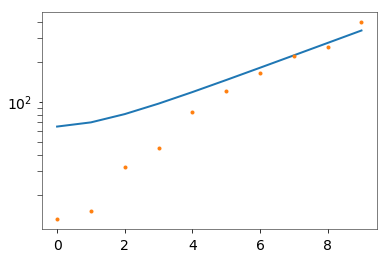

In [306]:
print(res_const.x,msle_cases)
plt.plot(sol.t,sol.y[2,:]+sol.y[3,:] )
plt.plot(xdata,ydata,'.')
plt.yscale('log')

# SEIIRR Model 

In [307]:
def seiirr_ivp(x,y,p,R0,Td,Tr,Tl):
    S,E,Iu,Id,Rd,Ru = y
    gamma_eff = (p * Td + (1-p) * Tr )**(-1)
#    beta = R0*gamma_eff  
    beta = R0/(p*Td)
    sigma = 1/Tl
    Sd = -beta * (Id + Iu) * S/N
    Ed = beta * (Id + Iu) * S/N - sigma * E
    Iud = (1-p) * sigma * E - Iu/Tr
    Idd = p * sigma * E - Id/Td
    Rdd = Id/Td
    Rud = Iu/Tr
    return Sd, Ed, Iud, Idd, Rdd, Rud

In [308]:
def eval_model_seiirr(params,xdata,ydata,Ti,population,return_sol=False): # params: to optimize over

    p,R0 = params
    N = population
    max_days=len(ydata)

    
    Rd0 = ydata[0]
    E0 = (Rd0 * (Ti + Td) * Tl) / (p * Ti**2)
    Id0 = Rd0 * Td / Ti
    Iu0 = Rd0 * (1/p-1) * (Ti + Td)/(Ti + Tr) * Tr/Tl
    Ru0 = Rd0 * (1/p-1) * (Ti + Td)/(Ti + Tr)
    S0 = N - (Rd0 + E0 + Id0 + Iu0 + Ru0 )
    
    sol = integrate.solve_ivp(seiirr_ivp, [0, max_days], [S0, E0, Iu0, Id0, Rd0, Ru0], args=(p,R0,Td,Tr,Tl), 
                    t_eval=xdata,method='RK45')



    optim_days = min(40, max_days)  # Days to optimise for
    weights = 1 / np.arange(1, optim_days+1)[::-1]  # Recent data is more heavily weighted

    msle_cases = mean_squared_log_error(ydata[-optim_days:], (sol.y[4,:])[-optim_days:], weights) 
   # msle_cases = mean_squared_error(ydata[-optim_days:], (sol.y[4,:])[-optim_days:], weights) 

    if return_sol == False:
        return msle_cases
    else:
        return msle_cases,sol

In [309]:
Tl = 7
Tr = 15
Td = 5
country='Spain'
population=df_pop[df_pop["Country (or dependency)"]=='Spain']["Population (2020)"].values[0] 
params=(0.225,1.5)
xdata,ydata,Ti=get_data(country,l=None)
msle_cases,sol = eval_model_seiirr(params,xdata,ydata,Ti,population,return_sol=True)
print(msle_cases)

4.156260171924978


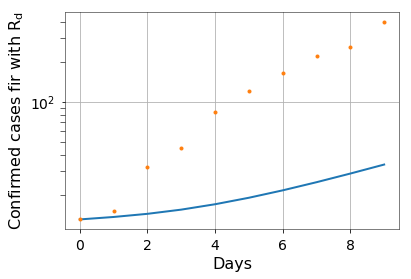

In [310]:
plt.plot(sol.t, sol.y[4,:],'-')
plt.plot(sol.t, ydata,'.')
plt.yscale('log')
plt.xlabel('Days')
plt.ylabel('Confirmed cases fir with $R_d$')
plt.grid()

In [311]:
bounds1=((0.01,0.9),(0.5,5.5))
no_bounds=((0.1,1),(1,15))
Tl = 7
Tr = 15
Td = 5
country='Spain'
population=df_pop[df_pop["Country (or dependency)"]=='Spain']["Population (2020)"].values[0] 

xdata,ydata,Ti=get_data(country,l=None)

res_const = minimize(eval_model_seiirr,([0.3, 1.2]), bounds=no_bounds,args=(xdata,ydata,Ti, population),method='L-BFGS-B')

msle_cases,sol=eval_model_seiirr(res_const.x,xdata,ydata,Ti,population,return_sol=True)
p,R0obs=res_const.x
beta = R0obs/(p*Td)
R0 = beta*(p* Td + (1-p)*Tr)

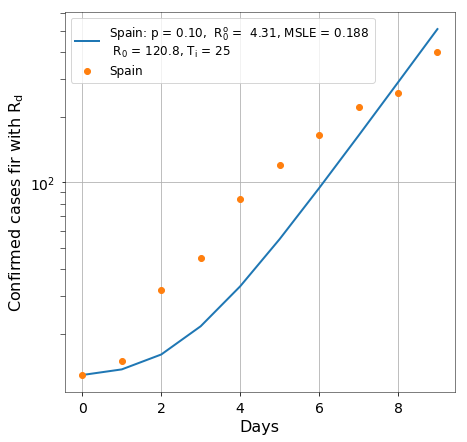

In [312]:
la= country + ": p = %.2f, "%p +" $R_0^o$ =  %3.2f, " %R0obs + 'MSLE = %.3f \n '%msle_cases + '$R_0$ = %.1f, '%R0 + '$T_i$ = %d'%Ti 
plt.figure(figsize=(7,7))
plt.plot(sol.t,sol.y[4,:],label = la )
plt.plot(xdata,ydata,marker='o',linestyle='',label=country)
plt.yscale('log')
plt.xlabel('Days')
plt.ylabel('Confirmed cases fir with $R_d$')
plt.grid()

plt.legend(fontsize=12)

In [313]:
import itertools
marker = itertools.cycle(( '*','+', '.', 'o', '*')) 
def fit_country_seiirr(country, population,bounds=no_bounds):
    xdata,ydata,Ti=get_data(country,l=14)

    res_const = minimize(eval_model_seiirr,([0.3, 1.2]), bounds=bounds,args=(xdata,ydata,Ti, population),method='L-BFGS-B')

    msle_cases,sol=eval_model_seiirr(res_const.x,xdata,ydata,Ti,population,return_sol=True)
    p,R0obs=res_const.x
    beta = R0obs/(p*Td)
    R0 = beta*(p* Td + (1-p)*Tr)
    la= country + ": p = %.2f, "%p +" $R_0^o$ =  %3.2f, " %R0obs + 'MSLE = %.3f \n '%msle_cases + '$R_0$ = %.1f, '%R0 + '$T_i$ = %d'%Ti 

    plt.plot(sol.t,sol.y[4,:],label = la )
    plt.plot(xdata,ydata,marker=next(marker),linestyle='',label=country)
    plt.yscale('log')
    plt.xlabel('Days')
    plt.ylabel('Confirmed cases fit with $R_d$')
    plt.grid()
    plt.legend(fontsize=12)
    return p,R0obs,R0,msle_cases,sol

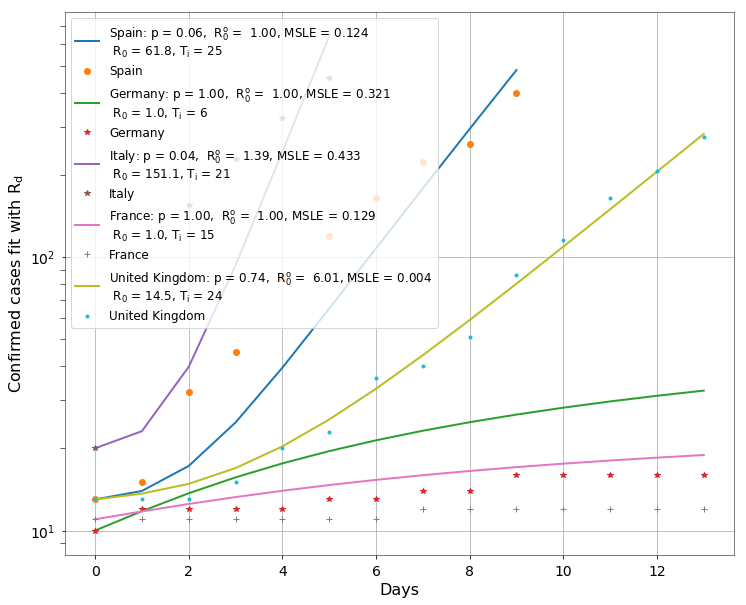

In [321]:
Tl = 5#6
Tr = 12#12
Td = 3#3

bounds1=((0.1,0.3),(1.5,3.5)) #physical bounds
bounds2=((0.01,0.9),(1.,5.5))
bounds3=((0.1,0.3),(1,15))
no_bounds=((0.01,1),(1,15))
bounds1=no_bounds
plt.figure(figsize=(12,10))
country='Spain'
population=df_pop[df_pop["Country (or dependency)"]=='Spain']["Population (2020)"].values[0]
_ = fit_country_seiirr(country,population,bounds=bounds1)

country='Germany'
population=df_pop[df_pop["Country (or dependency)"]=='Germany']["Population (2020)"].values[0]
_ = fit_country_seiirr(country,population,bounds=bounds1)

country='Italy'
population=df_pop[df_pop["Country (or dependency)"]=='Italy']["Population (2020)"].values[0]
_ = fit_country_seiirr(country,population,bounds=bounds1)

country='France'
population=df_pop[df_pop["Country (or dependency)"]=='France']["Population (2020)"].values[0]
_ = fit_country_seiirr(country,population,bounds=bounds1)

country='United Kingdom'
population=df_pop[df_pop["Country (or dependency)"]=='United Kingdom']["Population (2020)"].values[0]
_ = fit_country_seiirr(country,population,bounds=bounds1)

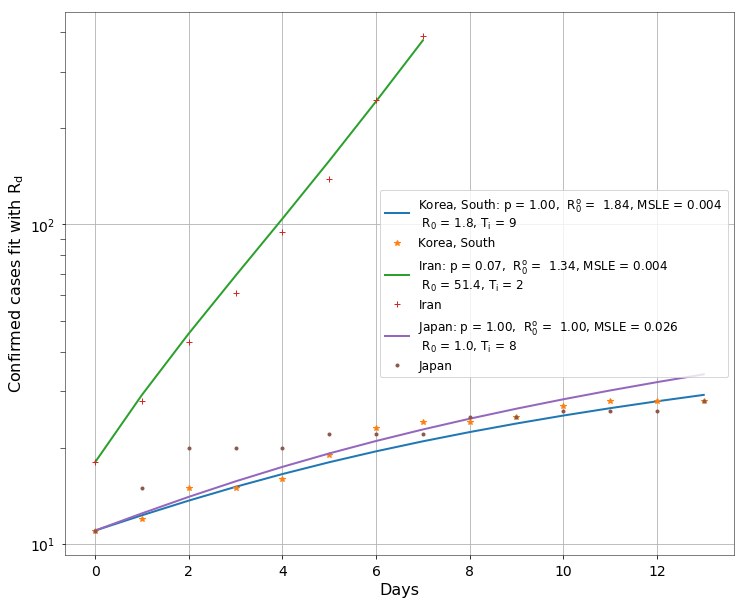

In [315]:
Tl = 7#6
Tr = 15#12
Td = 5#3

bounds1=((0.1,0.7),(1.7,3.3))
no_bounds=((0.01,1),(1,15))
bounds2=((0.01,0.9),(1.7,3.3))
bounds3=((0.2,1),(0.25,15))
bounds1=no_bounds
plt.figure(figsize=(12,10))
country='Korea, South'
population=df_pop[df_pop["Country (or dependency)"]=='South Korea']["Population (2020)"].values[0]
_ = fit_country_seiirr(country,population,bounds=bounds1)

country='Iran'
population=df_pop[df_pop["Country (or dependency)"]=='Iran']["Population (2020)"].values[0]
_ = fit_country_seiirr(country,population,bounds=bounds1)

country='Japan'
population=df_pop[df_pop["Country (or dependency)"]=='Japan']["Population (2020)"].values[0]
_ = fit_country_seiirr(country,population,bounds=bounds1)


In [126]:
# fit only to intitial data.